In [9]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
import datetime
import pickle
import time

In [10]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

def distance_from_end_month(i:pd.Timestamp):
    d=datetime.date(i.year,i.month,i.day)
    if d.month<12:
        begin_next_month = datetime.date(d.year,d.month+1,1)
    else:
        begin_next_month = datetime.date(d.year+1,1,1)
    diff_end = begin_next_month-d
    if d.day<=diff_end.days-1:
        return d.day
    else:
        return -(diff_end.days-1)

def pre_month_index(i:pd.Timestamp,months=1):
    pre30i = i-pd.Timedelta(days=30*months)
    if pre30i not in sample_df.index:
        return None
    dev = sample_df.loc[i].distance_end - sample_df.loc[pre30i].distance_end
    if sample_df.loc[i].distance_end!=i.day:
        dev = -dev
    if abs(dev)>5:
        dev = 0
    pre1mi = pre30i+pd.Timedelta(days=dev)
    return pre1mi

def pre_month_count(row:pd.Series,tp:str,months:int=1):
    i = row.name
    pre30i = i-pd.Timedelta(days=30*months)
    if pre30i not in sample_df.index:
        return None
    dev = row.distance_end - sample_df.loc[pre30i].distance_end
  
    pre1mi = pre30i+pd.Timedelta(days=dev)
    if pre1mi not in sample_df.index:
        return None
    return sample_df.loc[pre1mi][tp]

In [18]:
simplefilter("ignore", category=ConvergenceWarning)
pd.options.mode.chained_assignment = None
pivot_df = pd.read_csv('transactions_pivot.csv',index_col=0)
pivot_df.index = pd.DatetimeIndex(pivot_df.index)

types = pivot_df.columns

pivot_df['weekday'] = pivot_df.index.weekday
pivot_df['distance_end'] = pivot_df.index.to_series().apply(distance_from_end_month)
pivot_df['abs_distance'] = abs(pivot_df['distance_end'])

pivot_df.dropna(axis=0, inplace= True)
pivot_df

,VAT_calculation,authority_notice_created,direct_bank_transfer_created,expense_invoice,mass_letter_created,memo_voucher,new_receipts,payment_reminder_created,purchase_invoice,purchase_order,salary_slip,sales_invoice,sales_order,travel_invoice,weekday,distance_end,abs_distance
2021-01-01,118.0,74.0,303.0,79.0,0.0,1183.0,1326.0,88.0,12591.0,1.0,296.0,8049.0,7.0,106.0,4,1,1
2021-01-02,321.0,136.0,285.0,80.0,0.0,1583.0,1692.0,124.0,4703.0,0.0,426.0,6529.0,12.0,93.0,5,2,2
2021-01-03,390.0,255.0,443.0,134.0,0.0,2156.0,2748.0,150.0,3233.0,1.0,690.0,7816.0,18.0,165.0,6,3,3
2021-01-04,2014.0,1587.0,1973.0,770.0,0.0,14536.0,5313.0,1126.0,58151.0,49.0,10586.0,76376.0,442.0,814.0,0,4,4
2021-01-05,2428.0,1763.0,1406.0,545.0,6.0,18974.0,4445.0,1013.0,39097.0,46.0,7327.0,34170.0,349.0,563.0,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-17,2596.0,1866.0,3349.0,726.0,1.0,23195.0,6132.0,2098.0,46756.0,52.0,5829.0,29949.0,503.0,819.0,2,-14,14
2023-05-18,542.0,382.0,624.0,243.0,1.0,4472.0,3188.0,190.0,15135.0,3.0,783.0,7794.0,108.0,251.0,3,-13,13
2023-05-19,1673.0,1198.0,1329.0,473.0,3.0,14211.0,4526.0,1335.0,30145.0,32.0,2730.0,21595.0,320.0,582.0,4,-12,12
2023-05-20,142.0,81.0,274.0,77.0,0.0,1205.0,2016.0,72.0,6816.0,2.0,125.0,3039.0,39.0,105.0,5,-11,11


In [20]:
###   add supplementary data (weekday , ...)
def data_preparation(data, supp_data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        new_x = np.zeros((seq_length,4))
        _x = data[i:(i+seq_length)].tolist()
        
        new_x[:,0] = data[i:(i+seq_length)].reshape(-1)
        new_x[:,1] = supp_data[i:(i+seq_length), 0]
        new_x[:,2] = supp_data[i:(i+seq_length), 1]
        new_x[:,3] = supp_data[i:(i+seq_length), 2]
        
        _y = data[i+seq_length]
        #x.append(np.array(_x))
        x.append(new_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [21]:
class Net(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(Net, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(self.num_layers, -1, self.hidden_size)
        
        out = self.fc(h_out[-1,:,:])
        
        return out

In [22]:
class Predictor:
    def __init__(self):
        self.seq_length = 20
        self.res = []
    
    def train(self, trainX, trainY, training_set):
        num_epochs = 4000
        learning_rate = 0.01

        input_size = 4
        hidden_size = 5
        num_layers = 1

        num_classes = 1

        self.model = Net(num_classes, input_size, hidden_size, num_layers, self.seq_length)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        # Train the model
        for epoch in range(num_epochs):
            #print("trainX   ", trainX)
            outputs = self.model(trainX)
            optimizer.zero_grad()

            #print("output   ", outputs)
            #print("y   ", trainY)
            loss = criterion(outputs, trainY)

            loss.backward()

            optimizer.step()
            if epoch % 400 == 0:
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
        try:
            self.ARIMA_model = pm.auto_arima(training_set, 
                                  start_p=1, 
                                  start_q=1,
                                  test='adf', 
                                  max_p=6, max_q=6, 
                                  m=1, 
                                  d=None,
                                  seasonal=False, 
                                  trace=False, 
                                  error_action='ignore', 
                                  suppress_warnings=True,
                                  stepwise=True)
        except:
            self.ARIMA_model = None
            
    def test(self, dataX, dataY, train_size, test_size):
        self.model.eval()
        train_predict = self.model(dataX)

        data_predict = train_predict.data.numpy()
        dataY_plot = dataY.data.numpy()

        data_predict = self.scaler.inverse_transform(data_predict)
        dataY_plot = self.scaler.inverse_transform(dataY_plot)
        
        if self.ARIMA_model is None:
            arima_pred = np.zeros(test_size)
        else:
            arima_pred = self.ARIMA_model.predict(test_size)

        plt.axvline(x=train_size, c='r', linestyle='--')

        plt.plot(dataY_plot, label="original data")
        plt.plot(data_predict, label="LSTM")


        tarima = np.arange(train_size, len(dataX))
        plt.plot(tarima, arima_pred, label="arima")
        plt.suptitle('Time-Series Prediction')
        plt.legend()
        plt.show()
        
        
        
        
        #########  more specific plot
        
        thrs = int(len(dataX) * 0.2)
        
        plt.plot(dataY_plot[-thrs:], label="original data")
        plt.plot(data_predict[-thrs:], label="LSTM")


        tarima = np.arange(train_size, len(dataX))
        plt.plot(arima_pred[-thrs:], label="arima")
        plt.suptitle('Time-Series Prediction')
        plt.legend()
        plt.show()
        
        
        #########  more specific plot
        
        plt.plot(dataY_plot[-24:], label="original data")
        plt.plot(data_predict[-24:], label="LSTM")


        tarima = np.arange(train_size, len(dataX))
        plt.plot(arima_pred[-24:], label="arima")
        plt.suptitle('Time-Series Prediction')
        plt.legend()
        plt.show()
        
        ######################

        r2_sc_lstm = r2_score(dataY_plot[-len(arima_pred):], data_predict[-len(arima_pred):])
        r2_sc_arima = r2_score(dataY_plot[-len(arima_pred):], arima_pred)
        
        print("LSTM R2    ", r2_sc_lstm)
        print("ARIMA R2    ", r2_sc_arima)
        print("---------------------------------")
        self.res.append([r2_sc_lstm, r2_sc_arima])
        
    
    def run(self):
        
        for i in types:
            print("--")
            print(i)
            training_set = pivot_df[i].values.reshape(-1,1)
            supp_data = pivot_df[['weekday','distance_end','abs_distance']].values
            
            #plt.plot(training_set)
            #plt.show()
            
            zero_ind = np.where(training_set == 0) 

            self.scaler = MinMaxScaler()
            training_data = self.scaler.fit_transform(training_set)

            #seq_length = 4
            x, y = data_preparation(training_data, supp_data, self.seq_length)
            
            #print("x   ", x.shape)
            #print("x   ", x[0,:,:])

            train_size = int(len(y) * 0.8)
            test_size = len(y) - train_size

            dataX = Variable(torch.Tensor(np.array(x)))
            dataY = Variable(torch.Tensor(np.array(y)))

            trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
            trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

            testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
            testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
            
            start_time = time.time()
            self.train(trainX, trainY, training_set[:train_size+self.seq_length])
            print("train time (seconds):  ", (time.time()-start_time))
            start_time = time.time()
            self.test(dataX, dataY, train_size, test_size)
            print("prediction time (seconds):  ", (time.time()-start_time))
        


--
VAT_calculation
Epoch: 0, loss: 0.08950
Epoch: 400, loss: 0.00397
Epoch: 800, loss: 0.00241
Epoch: 1200, loss: 0.00205
Epoch: 1600, loss: 0.00179
Epoch: 2000, loss: 0.00161
Epoch: 2400, loss: 0.00149
Epoch: 2800, loss: 0.00139
Epoch: 3200, loss: 0.00133
Epoch: 3600, loss: 0.00125
train time (seconds):   56.80389451980591


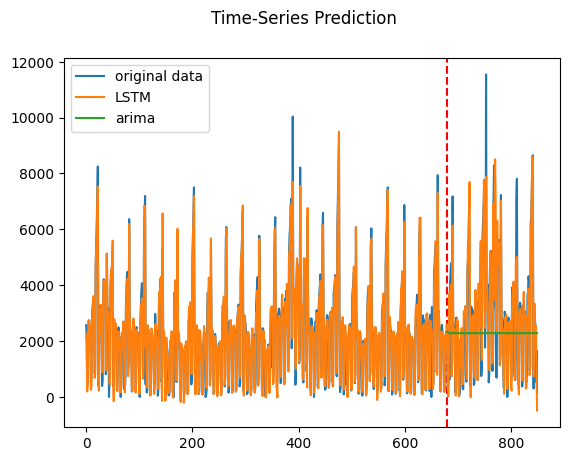

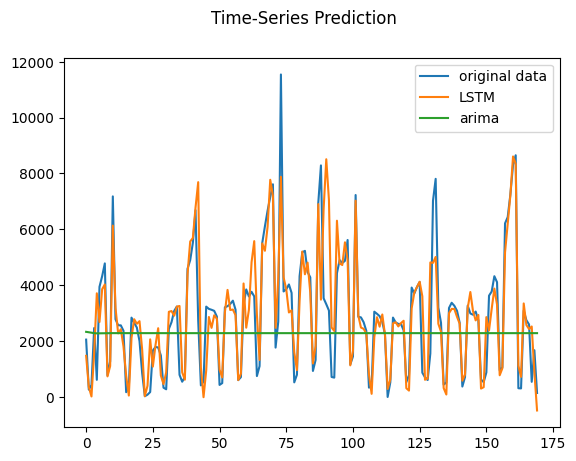

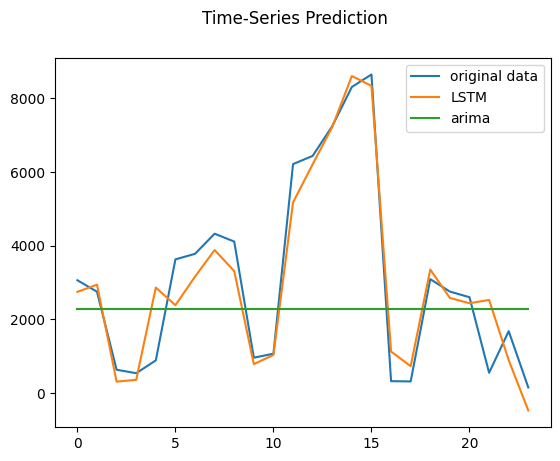

LSTM R2     0.6979532036929945
ARIMA R2     -0.06994275102119851
---------------------------------
prediction time (seconds):   0.566115140914917
--
authority_notice_created
Epoch: 0, loss: 0.10078
Epoch: 400, loss: 0.00416
Epoch: 800, loss: 0.00307
Epoch: 1200, loss: 0.00270
Epoch: 1600, loss: 0.00239
Epoch: 2000, loss: 0.00204
Epoch: 2400, loss: 0.00181
Epoch: 2800, loss: 0.00166
Epoch: 3200, loss: 0.00157
Epoch: 3600, loss: 0.00159
train time (seconds):   51.01856327056885


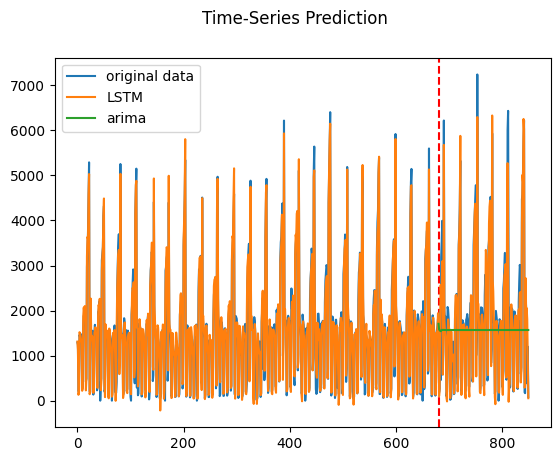

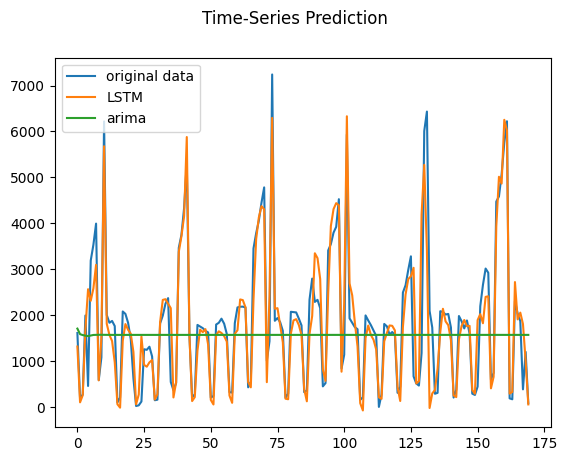

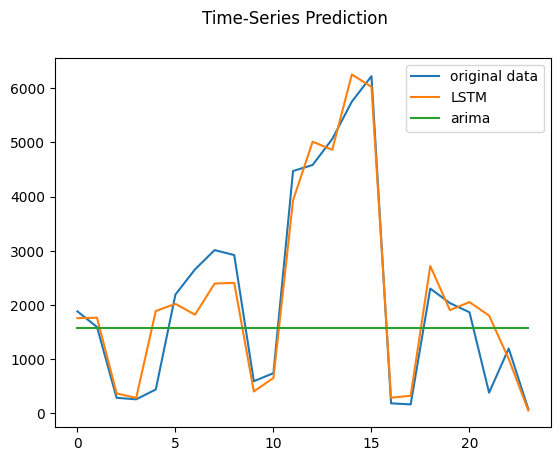

LSTM R2     0.82052904535487
ARIMA R2     -0.03677068809118911
---------------------------------
prediction time (seconds):   0.5788688659667969
--
direct_bank_transfer_created
Epoch: 0, loss: 0.19826
Epoch: 400, loss: 0.01026
Epoch: 800, loss: 0.00621
Epoch: 1200, loss: 0.00510
Epoch: 1600, loss: 0.00480
Epoch: 2000, loss: 0.00456
Epoch: 2400, loss: 0.00432
Epoch: 2800, loss: 0.00446
Epoch: 3200, loss: 0.00408
Epoch: 3600, loss: 0.00389
train time (seconds):   55.16505694389343


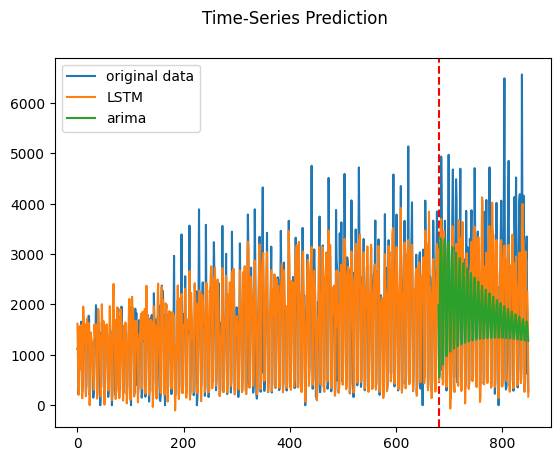

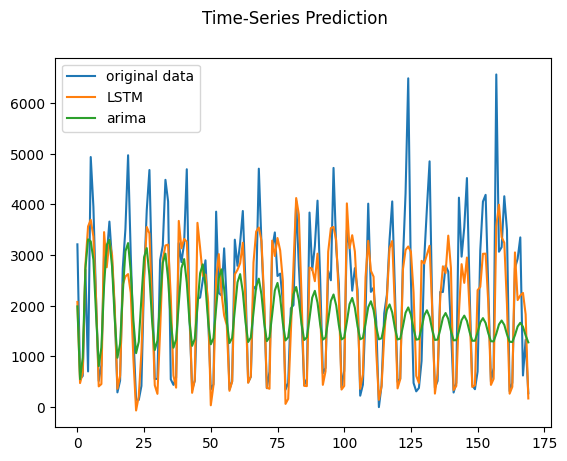

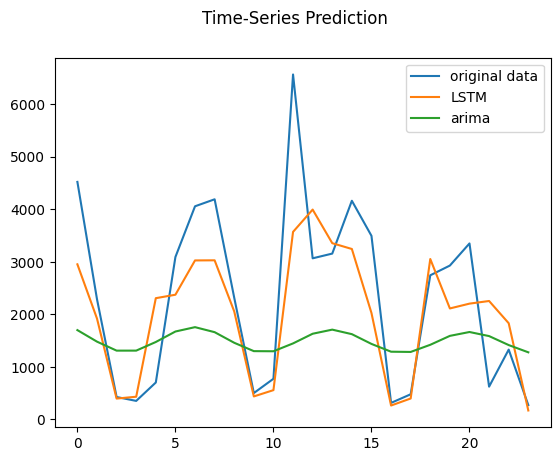

LSTM R2     0.6777466315603266
ARIMA R2     0.2595545704902388
---------------------------------
prediction time (seconds):   0.596895694732666
--
expense_invoice
Epoch: 0, loss: 0.17428
Epoch: 400, loss: 0.00692
Epoch: 800, loss: 0.00562
Epoch: 1200, loss: 0.00525
Epoch: 1600, loss: 0.00460
Epoch: 2000, loss: 0.00431
Epoch: 2400, loss: 0.00412
Epoch: 2800, loss: 0.00395
Epoch: 3200, loss: 0.00382
Epoch: 3600, loss: 0.00371
train time (seconds):   50.87762689590454


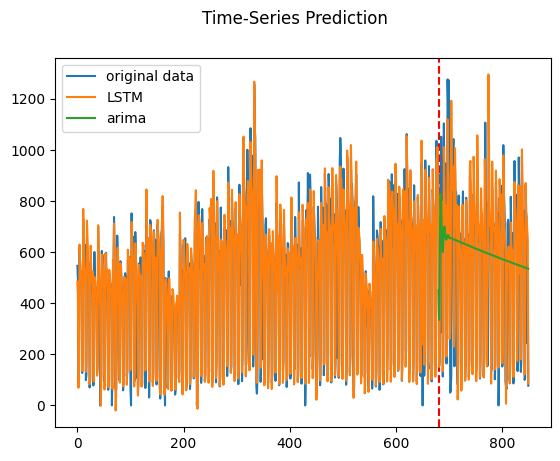

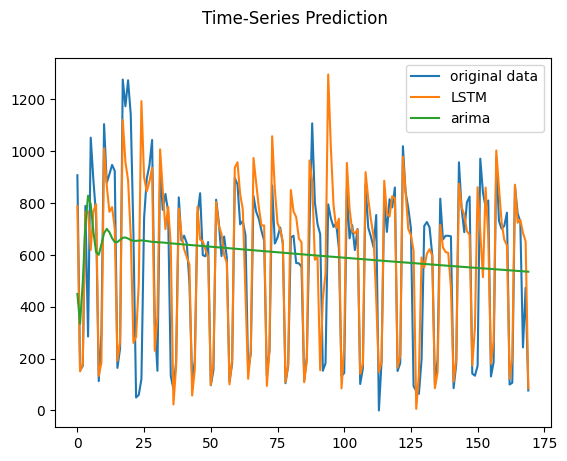

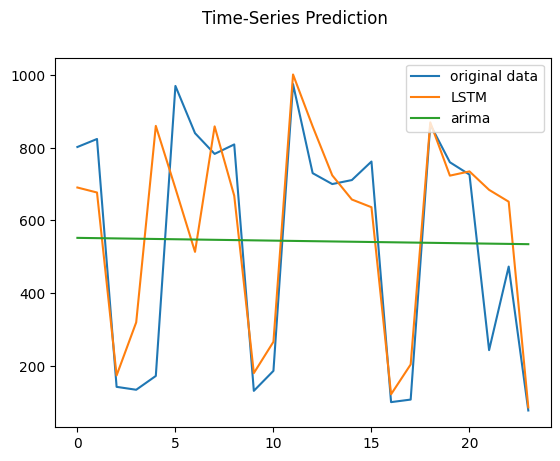

LSTM R2     0.6462632930047164
ARIMA R2     0.018030573794938
---------------------------------
prediction time (seconds):   0.5180516242980957
--
mass_letter_created
Epoch: 0, loss: 0.05269
Epoch: 400, loss: 0.00464
Epoch: 800, loss: 0.00269
Epoch: 1200, loss: 0.00200
Epoch: 1600, loss: 0.00171
Epoch: 2000, loss: 0.00157
Epoch: 2400, loss: 0.00153
Epoch: 2800, loss: 0.00146
Epoch: 3200, loss: 0.00130
Epoch: 3600, loss: 0.00123
train time (seconds):   73.23994088172913


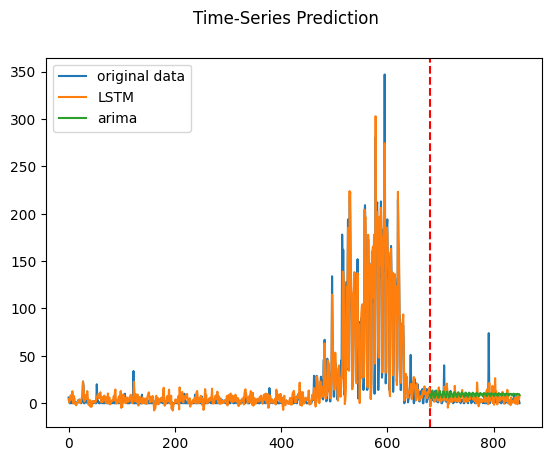

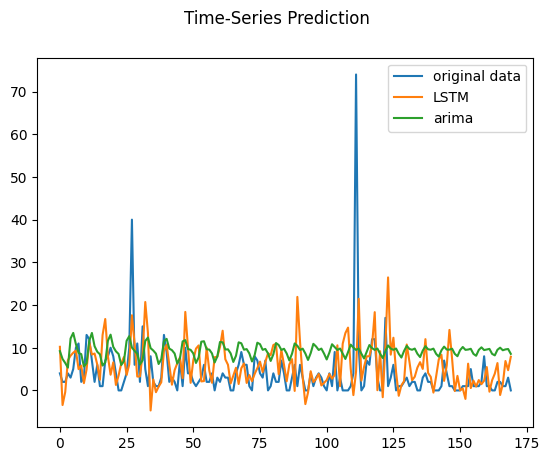

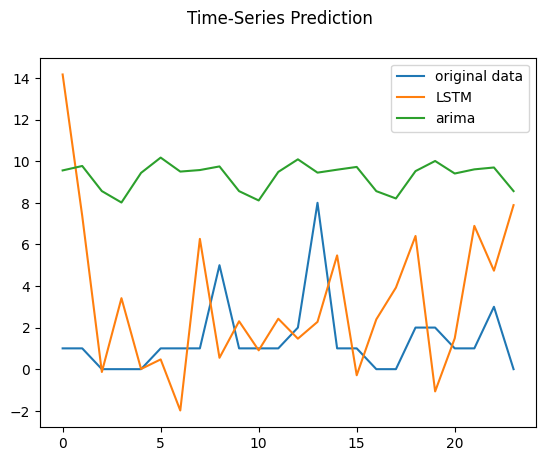

LSTM R2     -0.3364893015846384
ARIMA R2     -0.5302662265656379
---------------------------------
prediction time (seconds):   0.5064101219177246
--
memo_voucher
Epoch: 0, loss: 0.10902
Epoch: 400, loss: 0.00651
Epoch: 800, loss: 0.00548
Epoch: 1200, loss: 0.00500
Epoch: 1600, loss: 0.00450
Epoch: 2000, loss: 0.00419
Epoch: 2400, loss: 0.00371
Epoch: 2800, loss: 0.00327
Epoch: 3200, loss: 0.00323
Epoch: 3600, loss: 0.00311
train time (seconds):   58.49496030807495


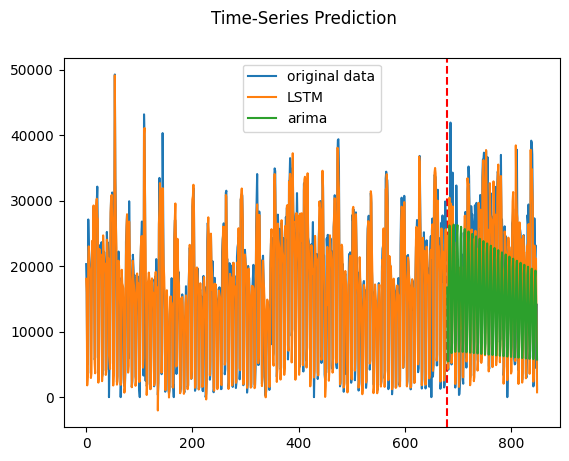

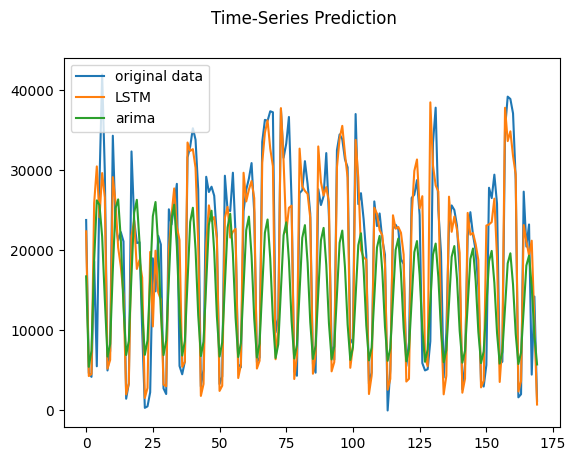

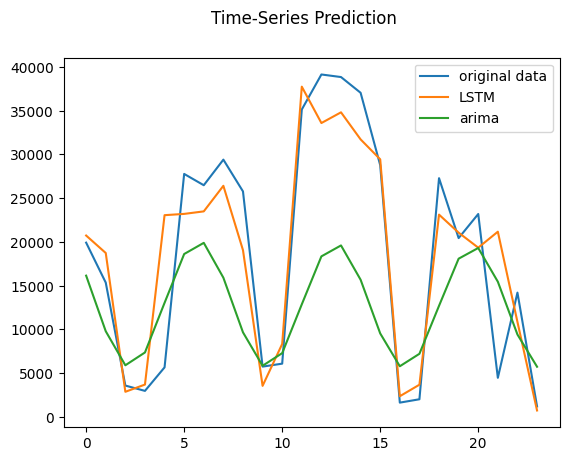

LSTM R2     0.7639449995484487
ARIMA R2     0.29428485454627096
---------------------------------
prediction time (seconds):   0.657127857208252
--
new_receipts
Epoch: 0, loss: 1.38614
Epoch: 400, loss: 0.02387
Epoch: 800, loss: 0.01606
Epoch: 1200, loss: 0.00598
Epoch: 1600, loss: 0.00507
Epoch: 2000, loss: 0.00468
Epoch: 2400, loss: 0.00446
Epoch: 2800, loss: 0.00421
Epoch: 3200, loss: 0.00404
Epoch: 3600, loss: 0.00387
train time (seconds):   59.414265632629395


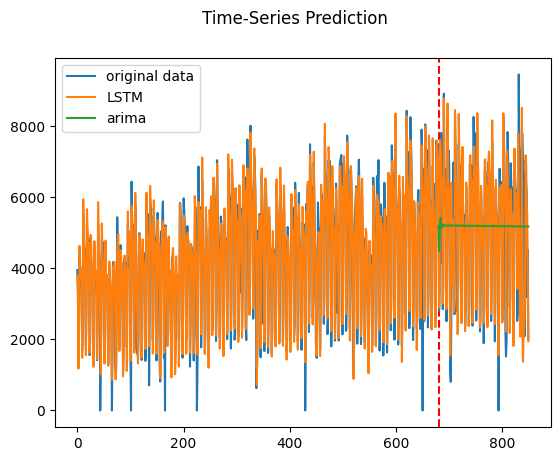

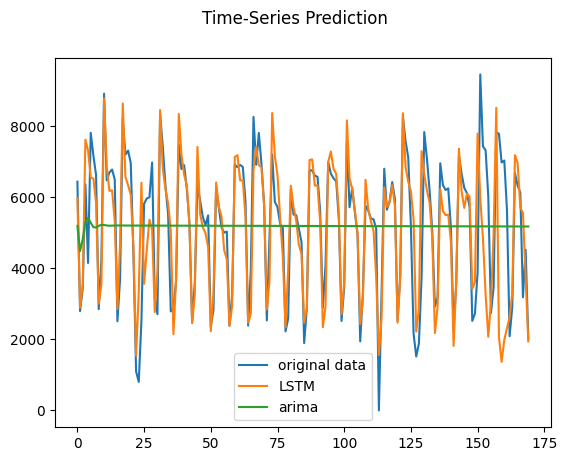

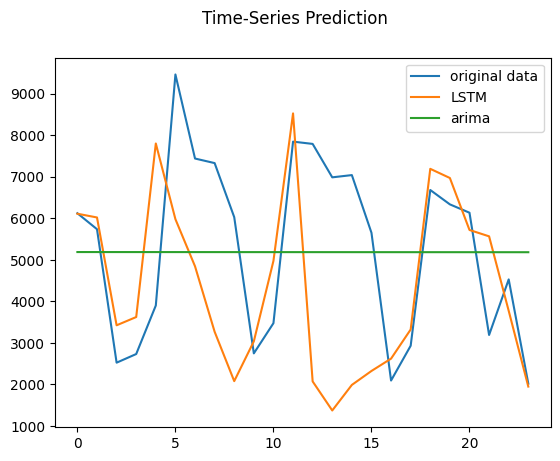

LSTM R2     0.515784104609169
ARIMA R2     0.006488925575291238
---------------------------------
prediction time (seconds):   0.6355922222137451
--
payment_reminder_created
Epoch: 0, loss: 0.07377
Epoch: 400, loss: 0.00883
Epoch: 800, loss: 0.00717
Epoch: 1200, loss: 0.00692
Epoch: 1600, loss: 0.00620
Epoch: 2000, loss: 0.00577
Epoch: 2400, loss: 0.00545
Epoch: 2800, loss: 0.00520
Epoch: 3200, loss: 0.00495
Epoch: 3600, loss: 0.00480
train time (seconds):   71.12172102928162


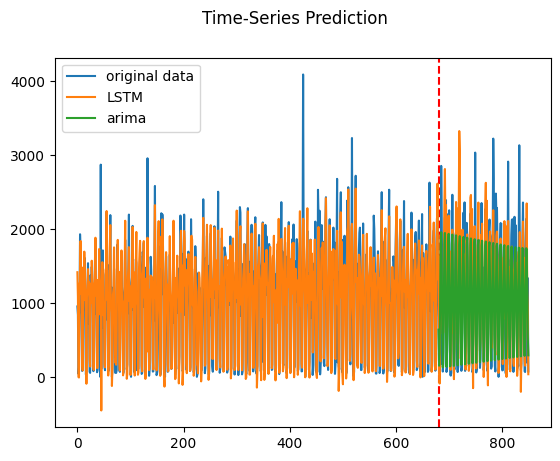

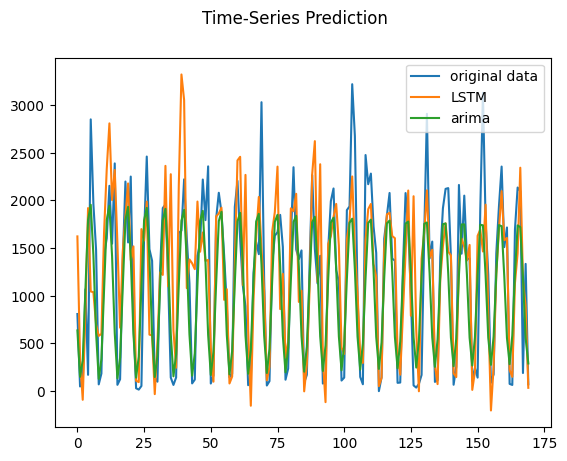

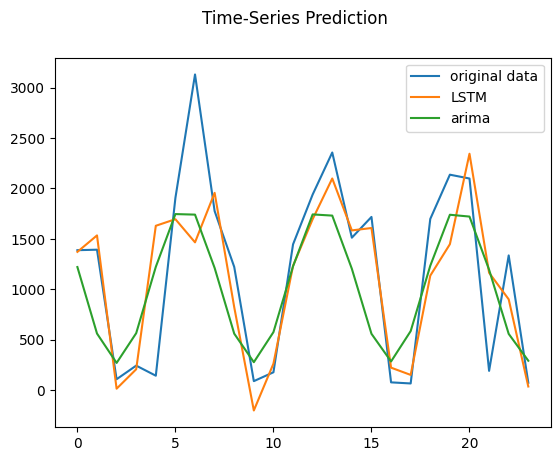

LSTM R2     0.4643222892477765
ARIMA R2     0.5832838992616688
---------------------------------
prediction time (seconds):   0.8726303577423096
--
purchase_invoice
Epoch: 0, loss: 0.61527
Epoch: 400, loss: 0.01838
Epoch: 800, loss: 0.01180
Epoch: 1200, loss: 0.00806
Epoch: 1600, loss: 0.00722
Epoch: 2000, loss: 0.00655
Epoch: 2400, loss: 0.00591
Epoch: 2800, loss: 0.00542
Epoch: 3200, loss: 0.00502
Epoch: 3600, loss: 0.00450
train time (seconds):   74.71553945541382


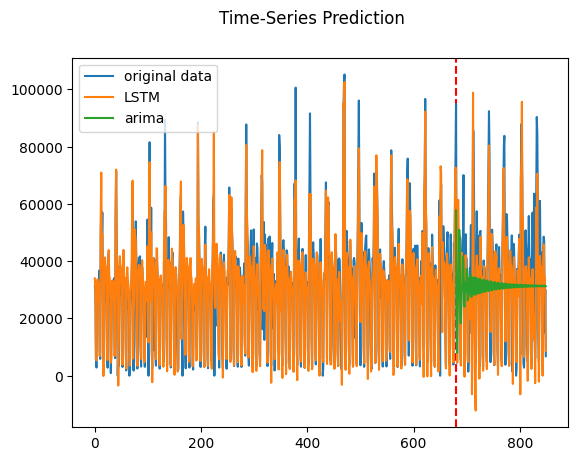

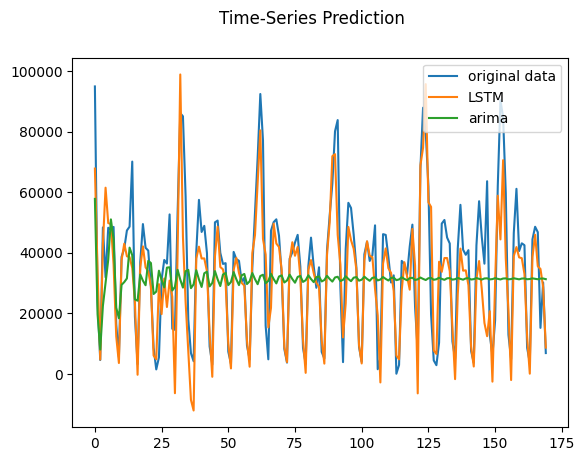

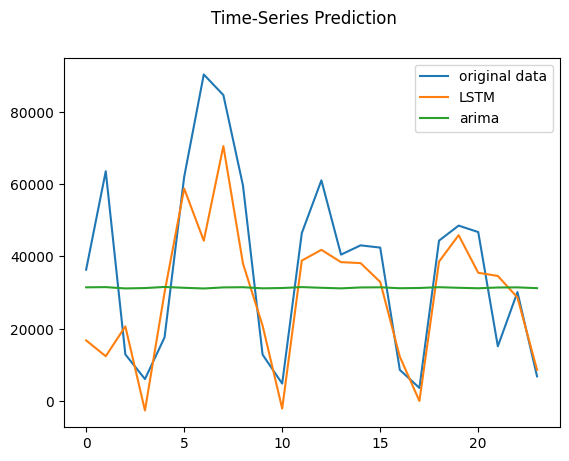

LSTM R2     0.6693225813850305
ARIMA R2     0.05266862081211121
---------------------------------
prediction time (seconds):   0.7133617401123047
--
purchase_order
Epoch: 0, loss: 0.28525
Epoch: 400, loss: 0.01266
Epoch: 800, loss: 0.00961
Epoch: 1200, loss: 0.00693
Epoch: 1600, loss: 0.00668
Epoch: 2000, loss: 0.00625
Epoch: 2400, loss: 0.00588
Epoch: 2800, loss: 0.00551
Epoch: 3200, loss: 0.00531
Epoch: 3600, loss: 0.00507
train time (seconds):   75.3555223941803


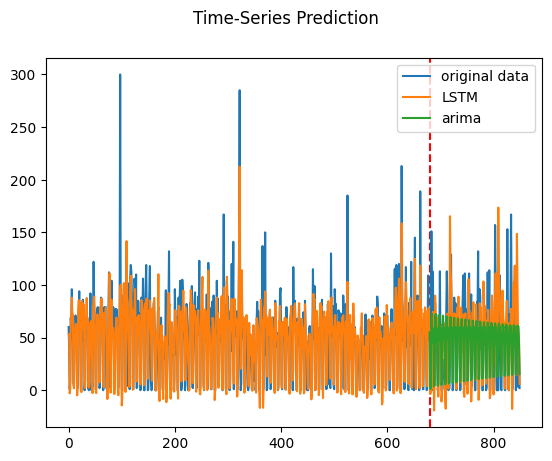

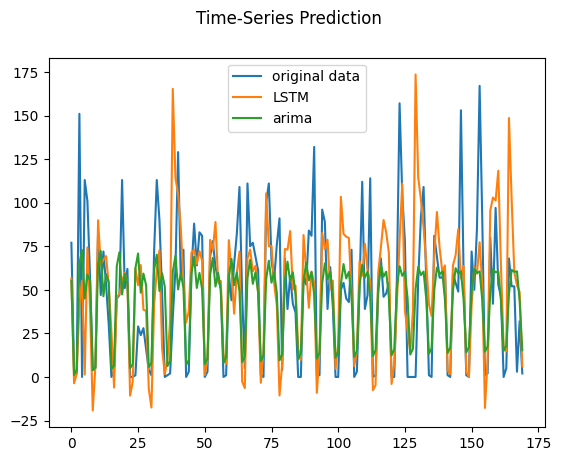

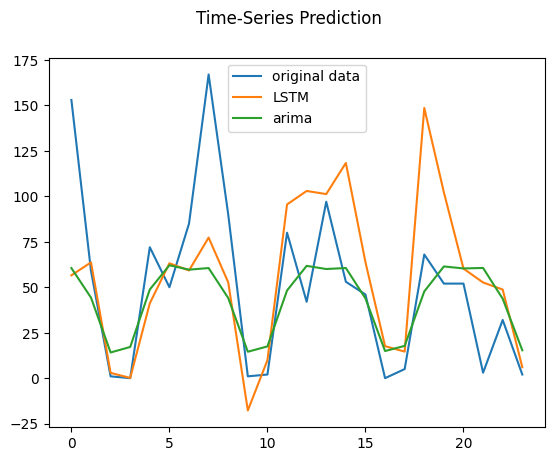

LSTM R2     0.1704988107967922
ARIMA R2     0.4276576244383484
---------------------------------
prediction time (seconds):   0.7581377029418945
--
salary_slip
Epoch: 0, loss: 0.12242
Epoch: 400, loss: 0.00753
Epoch: 800, loss: 0.00674
Epoch: 1200, loss: 0.00617
Epoch: 1600, loss: 0.00571
Epoch: 2000, loss: 0.00553
Epoch: 2400, loss: 0.00531
Epoch: 2800, loss: 0.00519
Epoch: 3200, loss: 0.00549
Epoch: 3600, loss: 0.00513
train time (seconds):   72.03401589393616


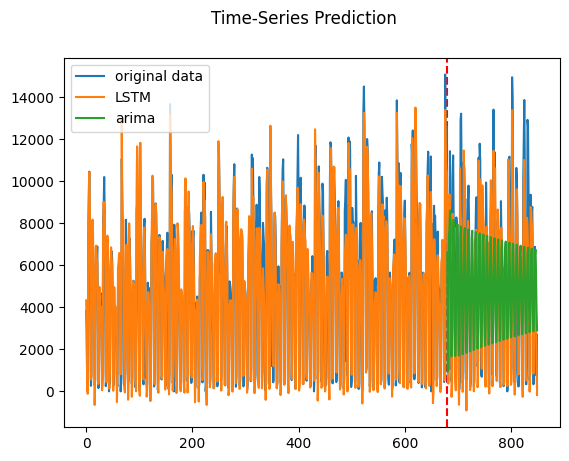

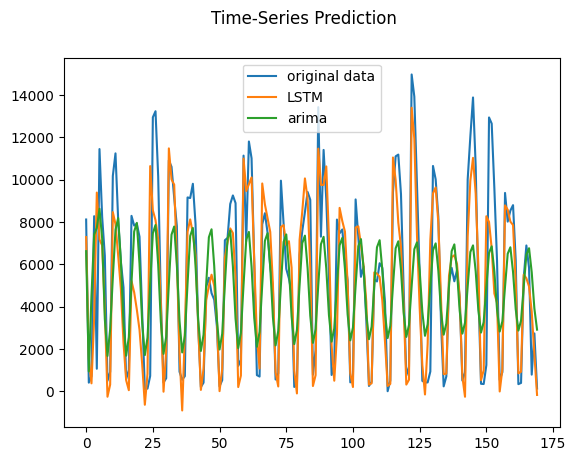

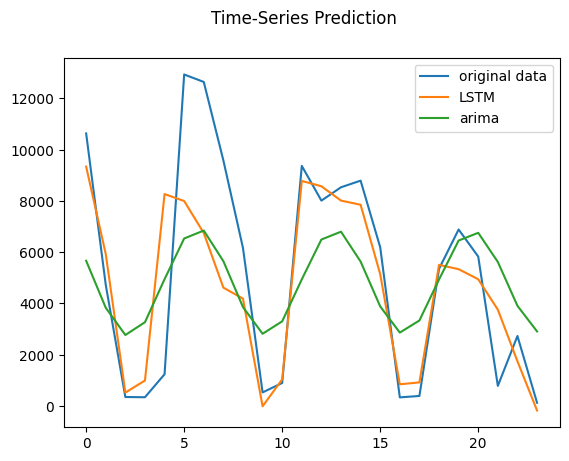

LSTM R2     0.7203213008941074
ARIMA R2     0.47112015359505977
---------------------------------
prediction time (seconds):   0.7360222339630127
--
sales_invoice
Epoch: 0, loss: 0.07337
Epoch: 400, loss: 0.00278
Epoch: 800, loss: 0.00213
Epoch: 1200, loss: 0.00285
Epoch: 1600, loss: 0.00202
Epoch: 2000, loss: 0.00187
Epoch: 2400, loss: 0.00202
Epoch: 2800, loss: 0.00162
Epoch: 3200, loss: 0.00163
Epoch: 3600, loss: 0.00161
train time (seconds):   68.27235651016235


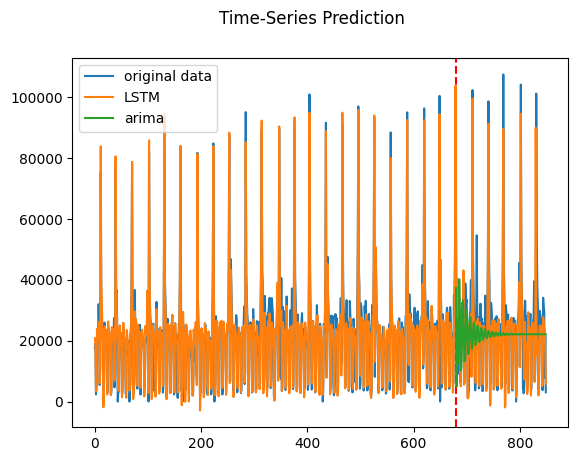

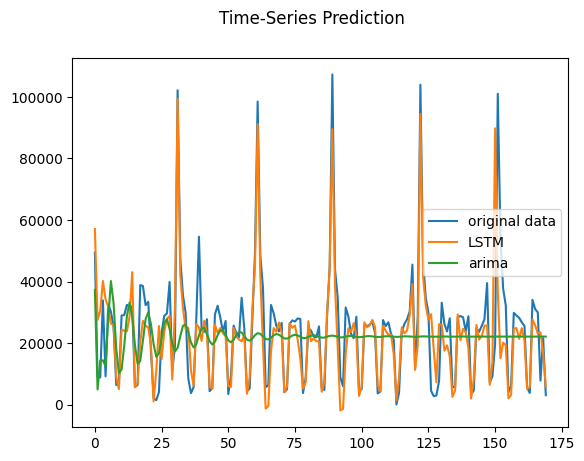

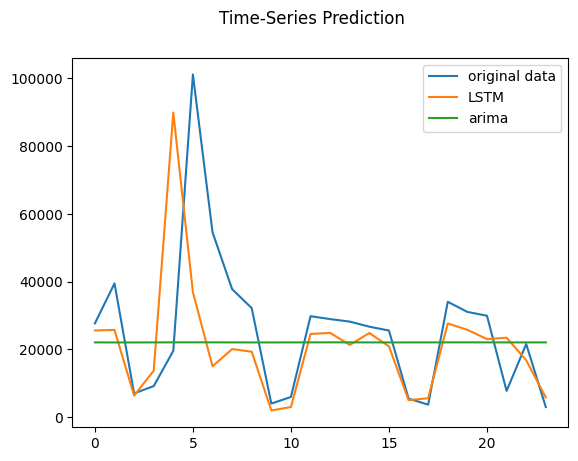

LSTM R2     0.6415177871293181
ARIMA R2     0.025325257418208347
---------------------------------
prediction time (seconds):   0.6082725524902344
--
sales_order
Epoch: 0, loss: 0.90589
Epoch: 400, loss: 0.01637
Epoch: 800, loss: 0.01506
Epoch: 1200, loss: 0.01302
Epoch: 1600, loss: 0.01111
Epoch: 2000, loss: 0.01092
Epoch: 2400, loss: 0.01023
Epoch: 2800, loss: 0.00899
Epoch: 3200, loss: 0.00870
Epoch: 3600, loss: 0.00896
train time (seconds):   70.68460464477539


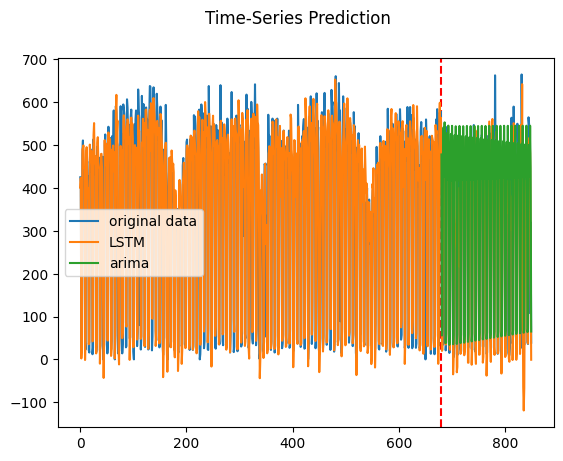

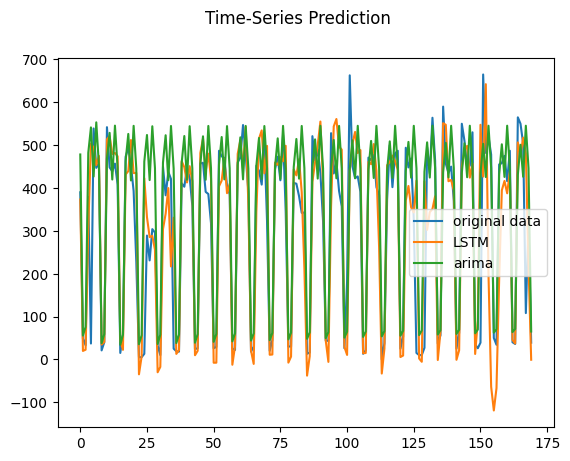

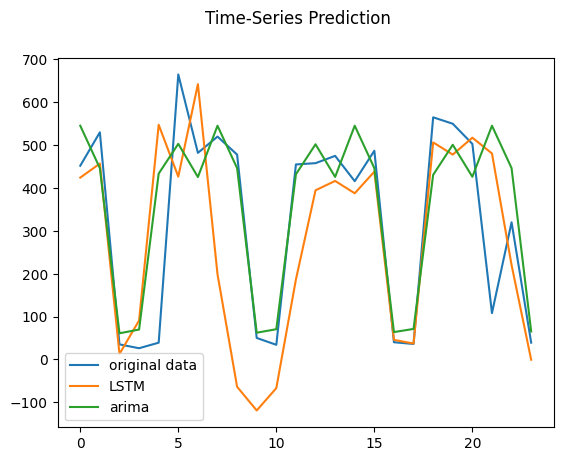

LSTM R2     0.6245826209293572
ARIMA R2     0.6538646008676336
---------------------------------
prediction time (seconds):   0.6333081722259521
--
travel_invoice
Epoch: 0, loss: 0.56773
Epoch: 400, loss: 0.00806
Epoch: 800, loss: 0.00573
Epoch: 1200, loss: 0.00488
Epoch: 1600, loss: 0.00415
Epoch: 2000, loss: 0.00392
Epoch: 2400, loss: 0.00372
Epoch: 2800, loss: 0.00322
Epoch: 3200, loss: 0.00312
Epoch: 3600, loss: 0.00297
train time (seconds):   58.20172095298767


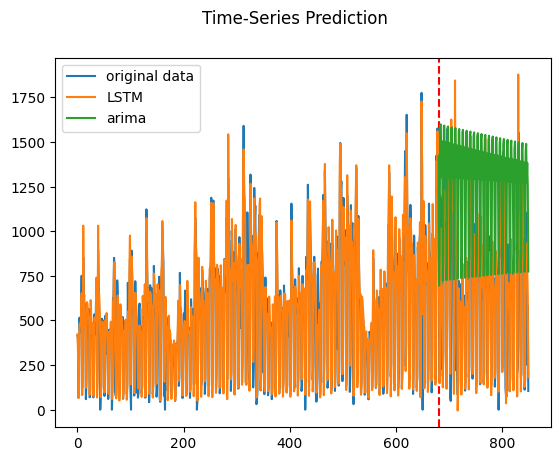

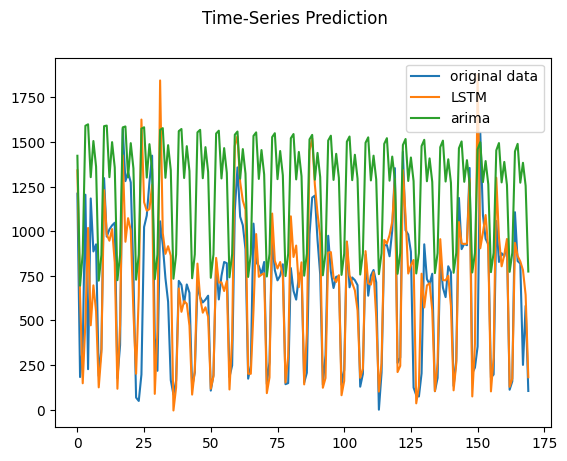

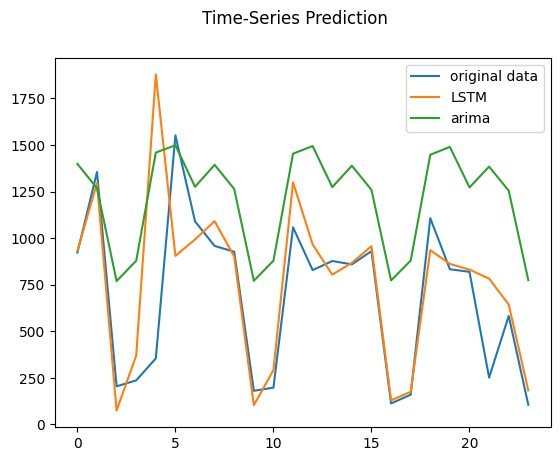

LSTM R2     0.5138185362654849
ARIMA R2     -1.596059603277976
---------------------------------
prediction time (seconds):   0.5034611225128174


In [23]:
agent = Predictor()
agent.run()